## Macromolecular model

This case study follows from the model presented in:

*Omta et al. 2017. Extracting physiological traits from batch and chemostate culture data. L&O*

The equations are below.

\begin{equation} \frac{dC}{dt} = (C_{syn} - E)P \end{equation}
\begin{equation} \frac{dP}{dt} = P_{syn}P \end{equation}
\begin{equation} \frac{dr}{dt} = \frac{1}{\tau}(r_0 - r) \end{equation}
\begin{equation} \frac{dN}{dt} = -\frac{dP}{dt} \end{equation}

\begin{equation} P_{syn} = \mu\left(\frac{N}{N+K}\right) \end{equation}
\begin{equation} r_0 = b\frac{P}{C} \end{equation}
\begin{equation} r_{cell} = \frac{C}{P} \end{equation}
\begin{equation} E = \frac{1}{2}m_{ex}\left(1+\tanh\left(r_{cell} - r_{ex}\right)\right) \end{equation}

In [3]:
library(rstan)
library(lattice)
options(mc.cores = parallel::detectCores())

In [12]:
mod_code <- "functions {
  real[] macro(real   t,           // time
               real[] x,           // state x[1]:CH  x[2]:PR, x[3]:Chl , x[4]:N
               real[] theta,
               real[] x_r,
               int[]  x_i) {       // parameters

    real KN    = theta[1];    
    real mu    = theta[2]; 
    real CHsyn = theta[3]; 
    real m_ex  = theta[4];  
    real R_ex  = theta[5];  
    real tau   = theta[6];
    real b     = theta[7];
    
    real CH = fmax(x[1],0.0);
    real PR = fmax(x[2],0.0);
    real Chl = fmax(x[3],0.0);
    real N = fmax(x[4],0.0);

    real PRsynth = theta[2]*N/(theta[1]+ pow(theta[1]*N,0.5) + N);
    real r0      = theta[7]*(PR/CH);
    //real Chl     = Chl*P;
    real Rcell   = x[1]/x[2];
    real excr    = 0.5*theta[4]*(1+tanh(Rcell - theta[5]));
    
    real dCH    = x[2]*(theta[3] - excr);
    real dr     = (1/theta[6])*(r0-x[3]);
    real dPR    = x[2]*PRsynth;
    real dN     = -dPR/(1+exp(-10000*x[4])); 

    return {dCH,dPR,dr,dN};
  }
}
data {
  int<lower = 0> n;           // num obs
  real t_obs[n];              // obs times
  real<lower = 0> y[n,4];     // observed variable at measurement times
}
parameters {
  real<lower = 0> theta[7];   // parameters
  real<lower = 0> x0[4];      // initial population
  real<lower = 1E-15> sigma[4]; // obs error
}
transformed parameters {
  real<lower=1E-15> x[n,4] = integrate_ode_rk45(macro, x0, 0, t_obs, theta, rep_array(0.0,0), rep_array(0,0), 1e-6, 1e-5, 1e3) ;
  for(i in 1:n){
    x[i,3] = x[i,3]*x[i,2]*1E6;
  }
}
model {
  x0[1]    ~ normal(0.1,1);
  x0[2]    ~ normal(0.1,1);
  x0[3]    ~ normal(10,10);
  x0[4]    ~ normal(0.1,1);  
  theta[1] ~ normal(0.002,3);
  theta[2] ~ normal(0.3,1);
  theta[3] ~ normal(5,10);
  theta[4] ~ normal(10,10);
  theta[5] ~ normal(13,10);
  theta[6] ~ normal(10,10); 
  theta[7] ~ normal(0.05,5); 
  
  for(i in 1:4){
    y[1:n,i] ~ normal(x[1:n,i], sigma[i]);
  }
}"

In [5]:
dat       <- read.csv('data/macromolecules.csv')

In [6]:
dat_flynn <- read.csv('data/flynn_macromolecules.csv')

In [7]:
dat[,2] <- dat[,2]*0.001                 #PR;
dat[,3] <- dat[,3]*1000                  #Chl;
dat[,4] <- dat[,4]*0.001                 #C
dat     <- merge(dat,dat_flynn[,c(1,4)]) #add environmental nitrogen to the data
dat[,5] <- dat[,5]*0.08325909            

In [8]:
head(dat)

t,N,chl,C,ammonium
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.0,0.0185714,15.6689,0.124167,0.10723771
5.5,0.0192857,19.0265,0.178333,0.10490645
6.0,0.0457143,20.1457,0.131667,0.10465668
6.5,0.0257143,45.8875,0.172500,0.10207564
7.0,0.0257143,45.8875,0.170000,0.10207564
7.5,0.0321429,55.9604,0.221667,0.09091893


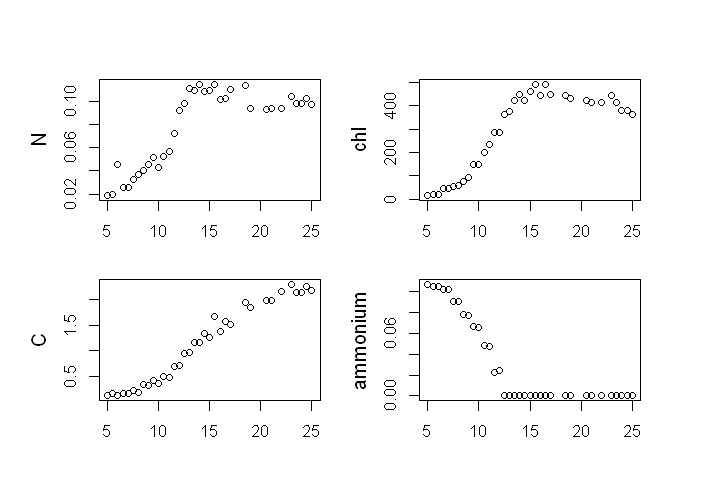

In [9]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(2,2),mar=c(2,3,2,2),oma=c(2,2,2,2))
for(i in 2:5){
    plot(dat[,1],dat[,i],ylab='',xlab='')
    mtext(side=2,colnames(dat)[i],line=2.5)
}

In [10]:
data <- list(n    =nrow(dat),
             t_obs=dat[,1],
             y    =dat[,c(4,2,3,5)])

In [13]:
mod <- stan_model(model_code=mod_code)

In [14]:
mcmc <- sampling(mod,data=data,iter=2000,chains=4,open_progress=TRUE)

Warning message in validityMethod(object):
"The following variables have undefined values:  x[1,1],The following variables have undefined values:  x[2,1],The following variables have undefined values:  x[3,1],The following variables have undefined values:  x[4,1],The following variables have undefined values:  x[5,1],The following variables have undefined values:  x[6,1],The following variables have undefined values:  x[7,1],The following variables have undefined values:  x[8,1],The following variables have undefined values:  x[9,1],The following variables have undefined values:  x[10,1],The following variables have undefined values:  x[11,1],The following variables have undefined values:  x[12,1],The following variables have undefined values:  x[13,1],The following variables have undefined values:  x[14,1],The following variables have undefined values:  x[15,1],The following variables have undefined values:  x[16,1],The following variables have undefined values:  x[17,1],The following

http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Warning message:
"The largest R-hat is 4.55, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat"Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess"

ERROR: Error in quantile.default(sims, 0.05): missing values and NaN's not allowed if 'na.rm' is FALSE


In [13]:
post <- extract(mcmc)

ERROR: Error in extract(mcmc): object 'mcmc' not found


In [43]:
mcmc

Inference for Stan model: 58793d2ca57b96e89c0ba5d43d3824ec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
theta[1]   0.02    0.00 0.01   0.01   0.01   0.02   0.03   0.05  1300    1
theta[2]   0.49    0.00 0.10   0.35   0.43   0.47   0.54   0.71  1152    1
theta[3]   1.29    0.00 0.07   1.16   1.24   1.29   1.33   1.42  2467    1
theta[4]  12.77    0.14 7.96   0.76   6.47  11.86  17.90  30.05  3138    1
theta[5]  14.86    0.17 8.41   1.16   8.49  14.27  20.44  33.14  2375    1
theta[6]  11.43    0.04 1.76   8.66  10.20  11.21  12.39  15.54  2497    1
theta[7]   0.05    0.00 0.00   0.04   0.05   0.05   0.05   0.05  1911    1
x0[1]      0.33    0.00 0.05   0.22   0.29   0.33   0.36   0.44  1655    1
x0[2]      0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  1227    1
x0[3]      0.00    0.00 0.00   0.00   0.00   0.00   0.01   0.01  1449   

In [44]:
post <- extract(mcmc)

In [26]:
plot_theta <- function(post,theta_names){   #theta_names has to be in the the same order 
	for(i in 1:dim(post$theta)[2]){
		hist(post$theta[,i],main='')
		abline(v=mean(post$theta[,i]),lwd=2)
		mtext(theta_names[i])
	}
}
plot_CV <- function(post,state_names){
	for(i in 1:dim(post$x)[3]){
		hist(post$sigma[,i]/mean(post$x[,,i]),main='')
		mtext(state_names[i])
	}; mtext(outer=TRUE,expression(sigma['x']/mu['x']),line=-1,cex=2)
}
plot_state <- function(post,state_names){
	for(i in 1:dim(post$x)[3]){
		plot(data$t_obs,colMeans(post$x[,,i]),type='l',bty='n')
		lines(data$t_obs,apply(post$x[,,i],2,function(x) quantile(x,probs=0.025)),lty=2)
		lines(data$t_obs,apply(post$x[,,i],2,function(x) quantile(x,probs=0.975)),lty=2)
		points(data$t_obs,data$y[,i])
		mtext(state_names[i])
	}
}	
plot_trace <- function(post,theta_names){
	for(i in 1:dim(post$theta)[2]){
		plot(post$theta[,i],pch=19,cex=0.2)
		abline(h=mean(post$theta[,i]),lwd=2)
		mtext(theta_names[i])
	}
}                           

In [46]:
theta_names <- c('KN','mu','CHsyn','m_ex','R_ex','tau','b')
state_names <- c('CH','PR','Chl','N')

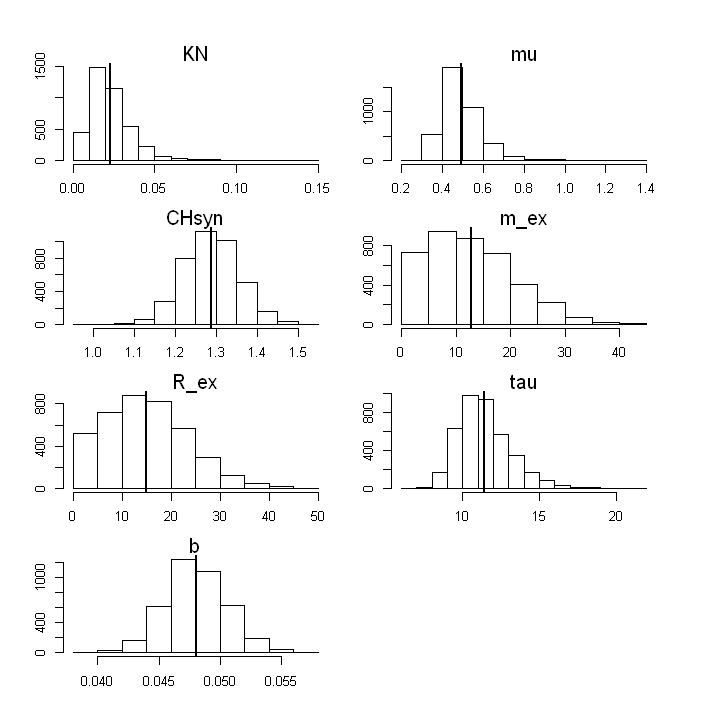

In [47]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(4,2),mar=c(2,2,2,2),oma=c(2,2,2,2))
	plot_theta(post=post,theta_names=theta_names)

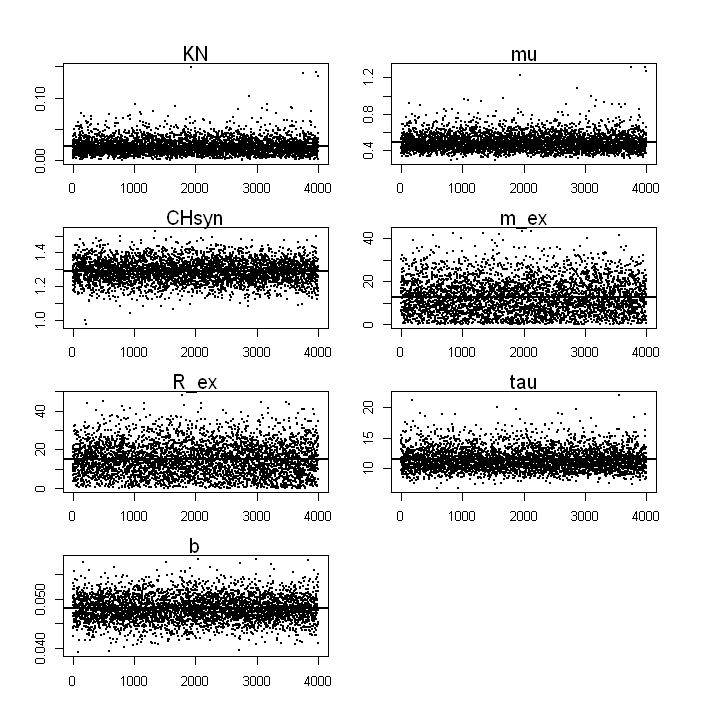

In [48]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(4,2),mar=c(2,2,2,2),oma=c(2,2,2,2))
	plot_trace(post=post,theta_names=theta_names)

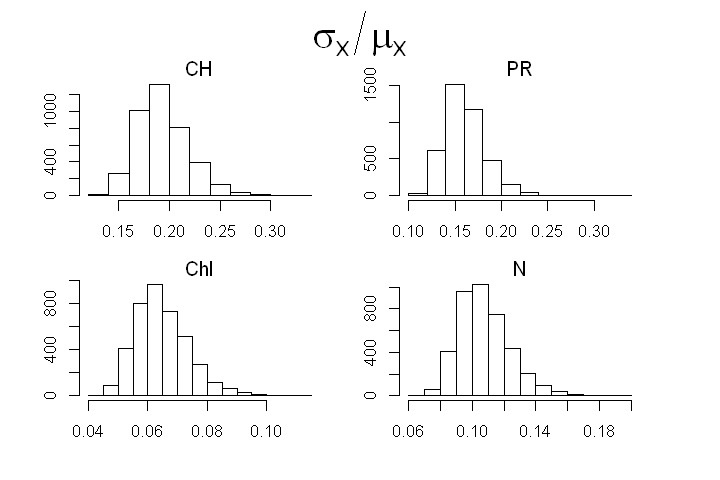

In [49]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(2,2),oma=c(2,2,2,2),mar=c(2,2,2,2))
	plot_CV(post=post,state_names=state_names)

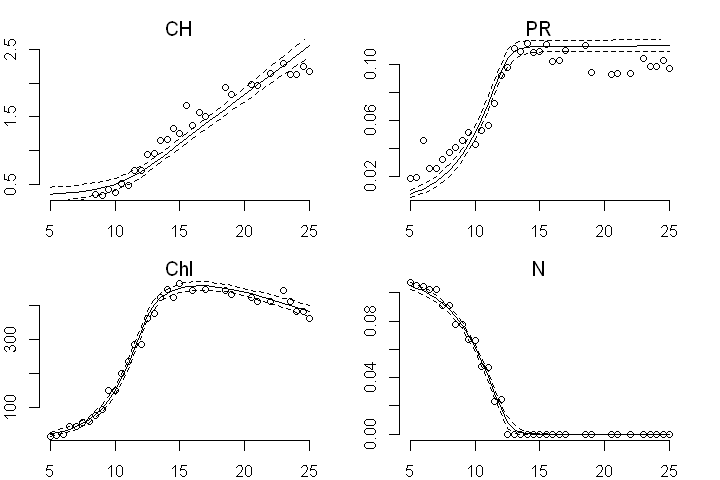

In [50]:
par(mfrow=c(2,2),mar=c(2,2,2,2),mar=c(2,2,2,2))
	plot_state(post=post,state_names=state_names)

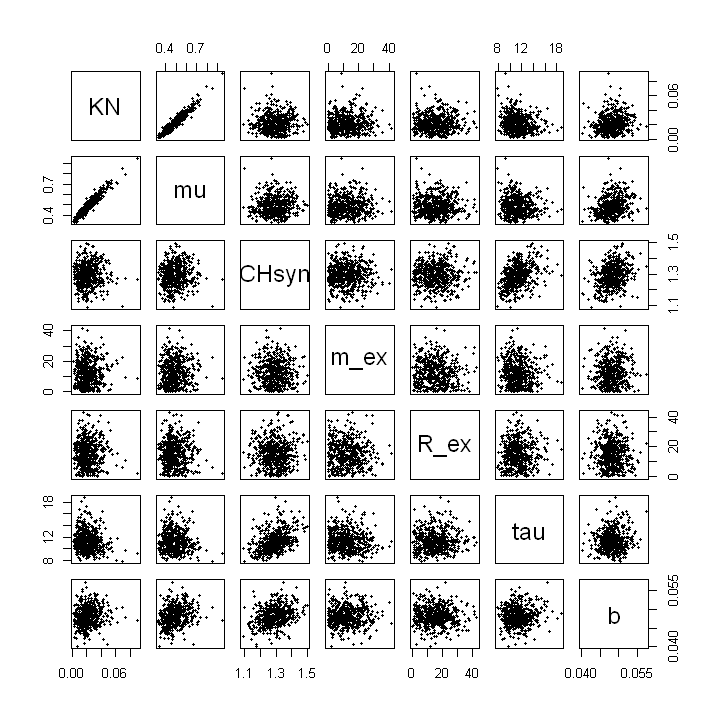

In [51]:
options(repr.plot.width=6, repr.plot.height=6)
pairs(post$theta[sample(1:nrow(post$theta),size=500),],pch=16,cex=0.5,labels=theta_names)

In [27]:
mod_code2 <- "functions {
  real[] macro(real   t,           // time
               real[] x,           // state x[1]:CH  x[2]:PR, x[3]:Chl , x[4]:N
               real[] theta,
               real[] x_r,
               int[]  x_i) {       // parameters

    // real KN    = theta[1];    
    real mu    = theta[1]; 
    real CHsyn = theta[2]; 
    real m_ex  = theta[3];  
    real R_ex  = theta[4];  
    real tau   = theta[5];
    real b     = theta[6];

    real PRsynth = theta[1]*x[4]/(x_r[1]+x[4]);
    real r0      = theta[6]*(x[2]/x[1]);
    real Chl     = x[3]*x[2];
    real Rcell   = x[1]/x[2];
    real excr    = (1.0/2.0)*theta[3]*(1+tanh(Rcell - theta[4]));  //avoid integer division
    
    real dCH    = x[2]*(theta[2] - excr);
    real dr     = (1/theta[5])*(r0-x[3]);
    real dPR    = x[2]*PRsynth;
    real dN     = -dPR/(1+exp(-10000*x[4])); 

    return {dCH,dPR,dr,dN};
  }
}
data {
  int<lower = 0> n;           // num obs
  real t_obs[n];              // obs times
  real<lower = 0> y[n,4];     // observed variable at measurement times
}
parameters {
  real<lower = 0> theta[6];   // parameters
  real<lower = 0> x0[4];      // initial population
  real<lower = 1E-15> sigma[4]; // obs error
}
transformed parameters {
  real x[n,4] = integrate_ode_rk45(macro, x0, -1, t_obs, theta, {0.02}, rep_array(0,0), 
    1e-6, 1e-5, 1e3) ;
  for(i in 1:n){
    x[i,3] = x[i,3]*x[i,2]*1E6;
  }
}
model {
  x0[1]    ~ normal(0.1,1);
  x0[2]    ~ normal(0.1,1);
  x0[3]    ~ normal(10,10);
  x0[4]    ~ normal(0.1,1);  
  // theta[1] ~ normal(0.002,3);
  theta[1] ~ normal(0.3,1);
  theta[2] ~ normal(5,10);
  theta[3] ~ normal(10,10);
  theta[4] ~ normal(13,10);
  theta[5] ~ normal(10,10); 
  theta[6] ~ normal(0.05,5); 
  
  for(i in 1:4){
    y[1:n,i] ~ normal(x[1:n,i], sigma[i]);
  }
}"

In [28]:
mod2 <- stan_model(model_code=mod_code2)

DIAGNOSTIC(S) FROM PARSER:
Info: integer division implicitly rounds to integer. Found int division: 1 / 2
 Positive values rounded down, negative values rounded up or down in platform-dependent way.



In [29]:
mcmc2 <- sampling(mod2,data=data,open_progres=TRUE)

In [30]:
post2 <- extract(mcmc2)

In [31]:
mcmc2

Inference for Stan model: 5875bbfee2c02d0e0d65f822418369e8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
theta[1]   0.47    0.00 0.02   0.43   0.46   0.47   0.49   0.52  1331 1.00
theta[2]   1.29    0.00 0.07   1.16   1.24   1.29   1.33   1.42  1696 1.00
theta[3]  12.76    0.15 7.94   0.90   6.52  11.81  17.88  30.40  2955 1.00
theta[4]  14.92    0.15 8.28   1.47   8.66  14.14  20.45  32.92  3204 1.00
theta[5]  11.47    0.04 1.79   8.60  10.23  11.26  12.45  15.60  2043 1.00
theta[6]   0.05    0.00 0.00   0.04   0.05   0.05   0.05   0.05  1786 1.00
x0[1]      0.33    0.00 0.05   0.22   0.29   0.33   0.36   0.44  1321 1.00
x0[2]      0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  1261 1.00
x0[3]      0.00    0.00 0.00   0.00   0.00   0.00   0.01   0.01  1329 1.00
x0[4]      0.11    0.00 0.00   0.11   0.11   0.11   0.11   0.12  1432 1.

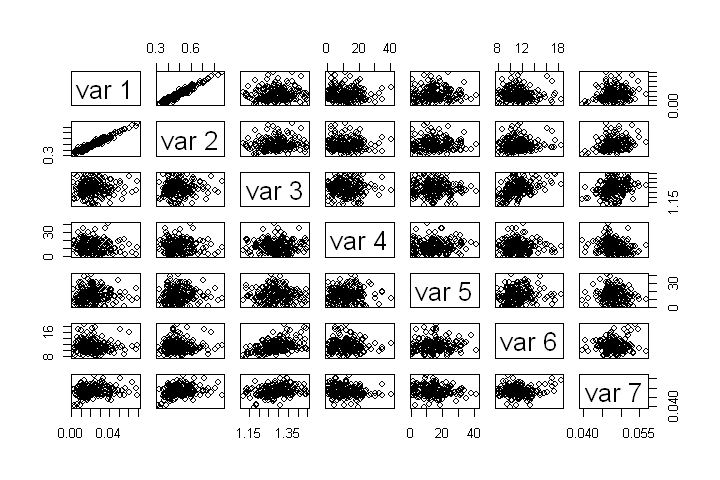

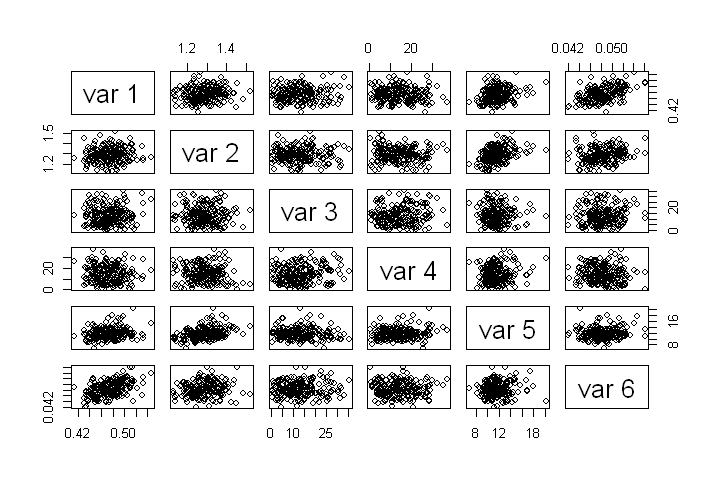

In [39]:
pairs(post$theta[sample(1:4000,200),])
pairs(post2$theta[sample(1:4000,200),])

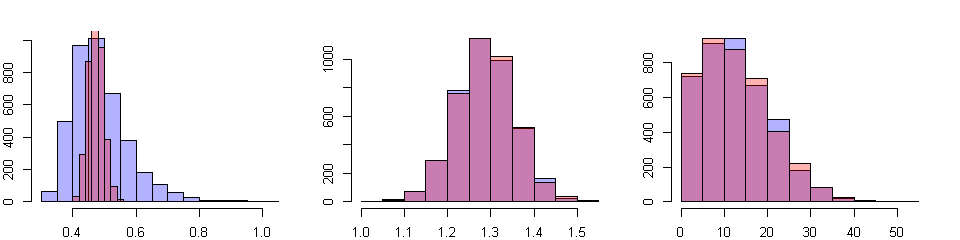

In [57]:
options(repr.plot.width=8, repr.plot.height=2)
par(mfrow=c(1,3),mar=c(2,2,2,2))
for(i in 1:3){
    hist(post$theta[,i+1],col=adjustcolor('blue',alpha.f=0.3),main='')
    hist(post2$theta[,i],add=TRUE,col=adjustcolor('red',alpha.f=0.3))
}
